In this notebook we will train our ResNet to predict fruits, aswell we'll use tensorboard for logging

In [ ]:
from scratch_dl.vision.configs.schemas import ResNetConfig
import torch.nn.functional as F
import torchvision
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader 
import numpy as np

config = ResNetConfig()

train_path =  config.data_dir / "Training"
test_path =  config.data_dir / "Test"

transform = transforms.Compose([
    transforms.Resize((100,100)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)


n_classes = len(train_dataset.classes)


In [2]:
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=config.num_workers)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.num_workers)

Batch shape torch.Size([64, 3, 100, 100])
Labels torch.Size([64])


Text(0.5, 1.0, '15')

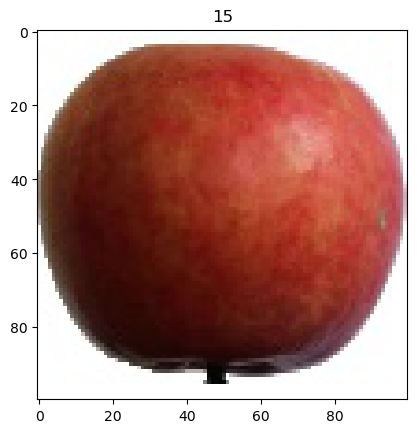

In [3]:
import matplotlib.pyplot as plt
imgs, train_labels = next(iter(train_loader))

print('Batch shape', imgs.size())
print('Labels', train_labels.size())

img = imgs[0].squeeze().permute(1,2,0)
label = train_labels[0]
plt.imshow(img)
plt.title(label.item())


In [ ]:
from scratch_dl.vision.models.resnet.resnet_model import ResNet
import torch.nn as nn
import torch.optim as optim

model = ResNet(n_classes=len(train_dataset.classes)).to(device=config.device)
imgs = imgs.to(config.device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= config.learning_rate)



In [5]:
print(f'Model Structure: {model}')
""" for name, param in model.named_parameters():
    print(f"Layer: {name}", f"| Params: {param.size()}") """

Model Structure: ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Identity()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

' for name, param in model.named_parameters():\n    print(f"Layer: {name}", f"| Params: {param.size()}") '

In [ ]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/experiment')


In [7]:


img_grid=torchvision.utils.make_grid(imgs)
writer.add_image('fruits_360',img_grid)
writer.add_graph(model, imgs)
writer.close()

In [8]:



def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''

    indices = torch.randperm(len(data))[:n]
    imgs = []
    labels = []
    for idx in indices:
        img, label = data[idx]
        imgs.append(img)
        labels.append(label)
    return torch.stack(imgs), torch.tensor(labels)

classes = train_dataset.classes    

# select random images and their target indices
images, labels = select_n_random(train_dataset, classes)

# get the class labels for each image
class_labels = [classes[lab] for lab in labels]

# log embeddings
features = images.view(images.size(0), -1)

writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images)
writer.close()

In [9]:

def images_to_probs(net, images):
    net.eval()
    with torch.no_grad():
        output = net(images)
        _, preds_tensor = torch.max(output, 1)
        preds = preds_tensor.cpu().numpy()
        probs = [F.softmax(el, dim=0)[i].item() for i, el in zip(preds_tensor, output)]
    return preds, probs

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        
def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx].cpu(), one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig


In [10]:
import os
import logging
from datetime import datetime

# Make sure the logs directory exists
os.makedirs("logs", exist_ok=True)

# Set up logging
log_filename = f"logs/train_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log"
logging.basicConfig(
    filename=log_filename,
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    filemode="a"
)

# Inside your training loop
for epoch in range(config.epochs):
    
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(config.device), labels.to(config.device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 1000 == 999:
            writer.add_scalar('training_loss',
                              running_loss / 1000,
                              epoch * len(train_loader) + i)
            
            writer.add_figure('preds vs actuals',
                            plot_classes_preds(model, inputs, labels),
                            global_step=epoch * len(train_loader) + i)

    acc = 100 * correct / total
    logging.info(f"Epoch {epoch+1}/{config.epochs} | Accuracy: {acc:.2f}%")


KeyboardInterrupt: 

In [11]:
model.eval()
correct, total = 0,0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(config.device), labels.to(config.device)
        outputs=model(inputs)
        _,predicted = torch.max(outputs, 1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()

final_acc = 100*(correct/total)
print(f"Final acc: {final_acc}%")

Final acc: 94.8373714384489%
